# SIR with spatial diffusion
by Karan Shah


In [1]:
#import necessary libraries
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.integrate import odeint
from scipy.linalg import block_diag

In [2]:
# Core plotting support
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

** Initialized with some values: **

In [3]:
#Define Global Variables
TAU = 0.8
K = 4
DELTA = 0.2
GRID_SIZE = 11

** build_matrix_D makes the D matrix: **

In [4]:
def build_matrix_D(m):
    D = sp.sparse.csr_matrix (sp.sparse.diags ([1, -4, 1], [-1, 0, 1], shape=(m, m)))
    D[0, 0] = -4
    D[0, 1] = 2
    D[m-1, m-1] = -4
    D[m-1, m-2] = 2
    return D.toarray()

print(build_matrix_D(4))

[[-4.  2.  0.  0.]
 [ 1. -4.  1.  0.]
 [ 0.  1. -4.  1.]
 [ 0.  0.  2. -4.]]


** build_matrix_A makes the matrix A using the matrix D: **

In [5]:
def build_matrix_A (m):
    D = build_matrix_D(m)

    
    A = np.zeros((m**2,m**2))

    for i in range(m):
        A[i*m:(i+1)*m,i*m:(i+1)*m] = D
    
#    A[2*m:,m:(m)**2-m]+=np.identity((m)**2-2*m)  #I to the left
    A[m:,0:(m)**2-m] += np.identity((m)**2-m)  #I to the left
    A[0:m**2-m,m:]+=np.identity((m)**2-m)  #I to the right
    #A[m:2*m,0:m]+=np.identity(m) * 2
    A[0:m,m:2*m]+=np.identity(m)
    A[m**2-m:m**2,m**2-2*m:m**2-m]+=np.identity(m) 
    
    return A

print(build_matrix_A(3))

[[-4.  2.  0.  2.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  2.  0.  0.  0.  0.]
 [ 0.  2. -4.  0.  0.  2.  0.  0.  0.]
 [ 1.  0.  0. -4.  2.  0.  1.  0.  0.]
 [ 0.  1.  0.  1. -4.  1.  0.  1.  0.]
 [ 0.  0.  1.  0.  2. -4.  0.  0.  1.]
 [ 0.  0.  0.  2.  0.  0. -4.  2.  0.]
 [ 0.  0.  0.  0.  2.  0.  1. -4.  1.]
 [ 0.  0.  0.  0.  0.  2.  0.  2. -4.]]


** f_diffusion uses build_matrix_A and computes the diffusion term ** 

In [6]:
def f_diffusion (I, A, c):
    #print (A.dot(I))
    f = c * A.dot(I)
    return f



** ode calculates the derivative at that time step **

In [7]:
def ode(y, t, c, tau = TAU, k = K, m = GRID_SIZE):
    i = y[0:m**2]
    s = y[m**2:2*m**2]
    r = y[2*m**2:3*m**2]
    
    f = np.zeros (y.shape)
    A = build_matrix_A(m)
    diff = f_diffusion(i, A, c)
    
    i_t = tau*i*s - i/k + diff*s
    s_t = -tau*i*s - diff*s
    
    f[0:m**2] = i_t
    f[m**2:2*m**2] = s_t
    return f

Final values after time 100.000000:
I: 0.000000 
S: 0.047099 
R: 0.952901 


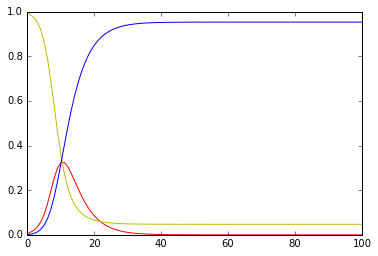


Using problem threshold of I<10^(-5) or S<10^(-5)
Sim stopped because I value below threshold.
Final values after time 62.000000 :
I: 0.000011 
S: 0.047101 
R: 0.952888 
Stopping point:62.000000


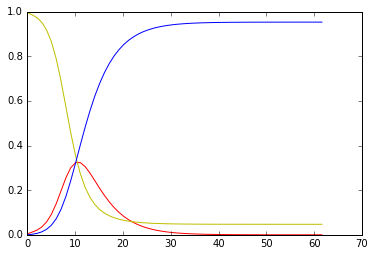

In [ ]:
def sim(grid_size = GRID_SIZE, tau = TAU, k = K, delta = DELTA, n_t = 100.0, t_max = 100):
    h = float (1)/(grid_size-1)
    
    i0 = np.zeros(grid_size * grid_size) 
    s0 = np.ones(grid_size * grid_size)
    r0 = np.zeros(grid_size * grid_size)
    s0[5 * grid_size + 5] = 0.5
    i0[5 * grid_size + 5] = 0.5
    
    y_0 = np.array([i0, s0])
    y_0 = np.reshape(y_0,2*grid_size**2)
    t_all = np.linspace(0, t_max, n_t)
    
    c = delta/(h**2)
    y_t = odeint(ode, y_0, t_all, args = (c, tau, k, grid_size))

    i = y_t[:,0:grid_size**2]
    s = y_t[:,grid_size**2:2*grid_size**2]
    r = 1-(i+s)
    
    #print((np.sum(i,axis=1)).shape)
    i_sum = abs(np.sum(i,axis=1)/grid_size**2)
    s_sum = abs(np.sum(s,axis=1)/grid_size**2)
    r_sum = abs(np.sum(r,axis=1)/grid_size**2)
    
    print("Final values after time %f:\nI: %f \nS: %f \nR: %f "% (t_max, i_sum[-1] ,s_sum[-1] ,r_sum[-1]))
    plt.plot (t_all, i_sum, 'r', t_all, s_sum, 'y', t_all, r_sum, 'b')
    plt.show()

############Code for condition according to 21.5a  
    t_i=np.where(i_sum > 10**(-5))[-1]
    t_s=np.where(s_sum > 10**(-5))[-1]    
    t_cond = min(t_i[-1],t_s[-1])

    print("\nUsing problem threshold of I<10^(-5) or S<10^(-5)")
    if(t_i[-1]>t_s[-1]):print("Sim stopped because S value below threshold.")
    else: print("Sim stopped because I value below threshold.")
    print("Final values after time %f :\nI: %f \nS: %f \nR: %f "% (t_cond, i_sum[t_cond] ,s_sum[t_cond] ,r_sum[t_cond]))
    print("Stopping point:%f" %(t_cond*t_max/n_t))
    
    plt.figure()

    plt.plot (t_all[:t_cond], i_sum[:t_cond], 'r', t_all[:t_cond], s_sum[:t_cond], 'y', t_all[:t_cond], r_sum[:t_cond], 'b')
    plt.show()
    


sim()

## Interactive simulation
Note: It can get pretty slow.

In [ ]:
from ipywidgets import interact

interact (sim
          , grid_size = (0,50,5)
          , tau=(0.0, 2.0, 0.01)
          , rho=(0.0, 2.0, 0.01)
          , delta=(0.0,2.0,0.01)
          , t_max=(0.0, 100.0, 10.0)
          , n_t=(1, 500, 50)
         )